In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import collections
import lqg1d
import json

import numba

In [2]:
COL_T = 0
COL_J = 1
COL_THETA = 2
COL_SIGMA = 3
COL_GRAD_K = 4
COL_GRAD_SIGMA = 5
COL_GRAD_MIXED = 6

### Experiment types
0. : ONLY_THETA
1. : THETA_AND_SIGMA
2. : THETA_AND_MIXED
3. : LOCAL_STEP_LENGTH
4. : FAR_SIGHTED_STEP
5. : ONLY_DELTA


In [3]:
col_to_legend = {0:'Timestep', 
                 1:'J',
                 2:'Theta', 
                 3:'Sigma', 
                 4:'Grad_k', 
                 5:'Grad_sigma', 
                 6:'Grad_mixed'}

In [4]:
COL_PARAM_TYPE = 0           
COL_PARAM_THETA = 1
COL_PARAM_SIGMA = 2
COL_PARAM_ALPHA_SIGMA = 3
COL_PARAM_ITERATIONS = 4
COL_PARAM_EPS = 5
COL_PARAM_FILENAME = 6
COLS = ['LAMBDA', 'THETA', 'SIGMA', 'ALPHA_SIGMA', 'MAX_ITERATIONS', 'EPS', 'FILENAME']

In [5]:
def load_dataframe(folder):
    experiments = []
    for experiment in glob.glob(os.path.join(folder, '*_params.json')):
        with open(experiment, 'r') as f:
            params = json.load(f)

        experiments.append({k.upper():i for k,i in params.items()})
    experiments_df = pd.DataFrame(experiments)
    
    return experiments_df

In [6]:
def load_from_dataframe(df):
    return [np.load(f) for f in df['FILENAME'].values]
        

In [7]:
def filter_experiments(**kwargs):
    df_filtered = kwargs['df']
    for k,v in kwargs.items():
        if v is not None:
            try:
                if isinstance(v, list):
                    df_filtered = df_filtered[df_filtered[k.upper()].isin(v)]
                else:
                    df_filtered = df_filtered[df_filtered[k.upper()] == v]
            except:
                pass
    return df_filtered

In [8]:
def my_plot(**kwargs):
    data_params = filter_experiments(**kwargs)
    data_params = data_params.sort_values(by=list(data_params.columns))

    data = load_from_dataframe(data_params)

    plt.rcParams["figure.figsize"] = (15,13)
    
    def plot_lines(**kwargs):
        if 'max_t' in kwargs:
            MAX_T = kwargs['max_t']
        else:
            MAX_T = -1

        if isinstance(kwargs['value'], list):
            params = kwargs
            ll = len(kwargs['value'])
            i = 1
            for v in kwargs['value']:
                plt.subplot((ll + 1)//2, 2, i)
                i+=1
                params['value'] = v
                plot_lines(**params)
        else:
            for d in data:
                x = d[0:MAX_T,COL_T]
                y = d[0:MAX_T,kwargs['value']]
                plt.plot(x, y)
                plt.xlabel('Timesteps')
                plt.ylabel(col_to_legend[kwargs['value']])
                plt.title(col_to_legend[kwargs['value']])

    plot_lines(**kwargs)
    
    # Build legend
    
    free_vars = []
    for k,v in kwargs.items():
        if v is None or (k.upper() in data_params.columns and isinstance(v, list)):
            free_vars.append(k)

    free_vars = [s.upper() for s in free_vars]

    legend = [' '.join(map(lambda x : ': '.join(x), zip(data_params.loc[:,free_vars].columns.values, s))) for s in data_params.loc[:,free_vars].values]

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        

In [9]:
BASE_FOLDER = 'experiments_lambda_new'

experiments_df = load_dataframe(BASE_FOLDER)

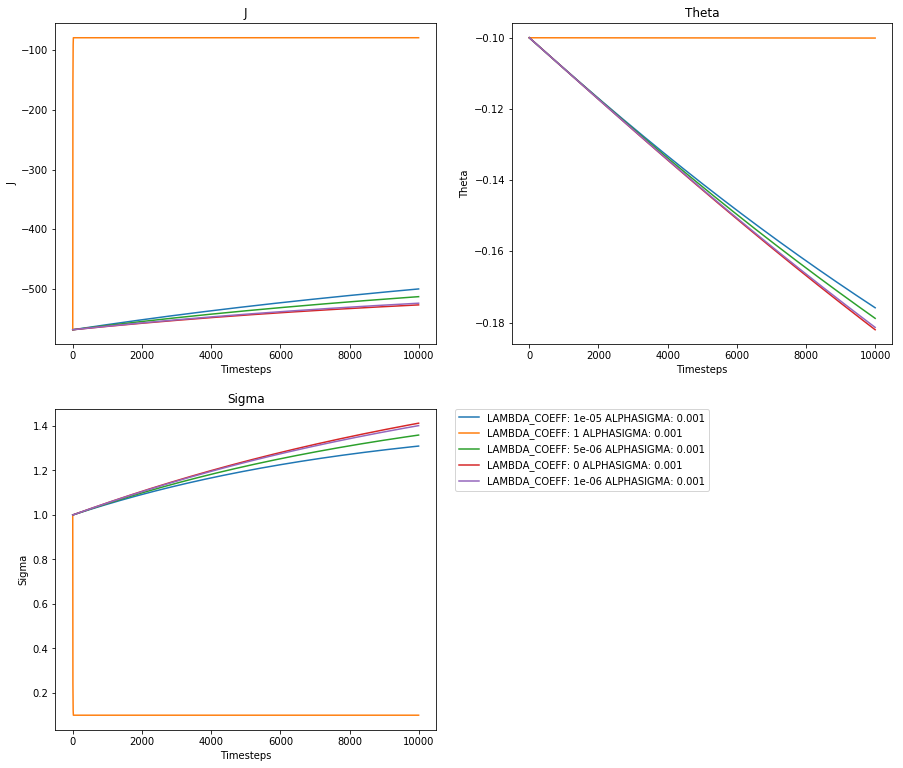

In [11]:
my_plot(lambda_coeff=None, 
        theta='-0.1', 
        alphaSigma = ['0.001'], 
        sigma='1',
        value=[COL_J, COL_THETA, COL_SIGMA], 
        max_t=-1,
        df = experiments_df)

In [ ]:
import math
lqg_env = lqg1d.LQG1D()

#
# Compute constants
#
R = np.asscalar(lqg_env.Q*lqg_env.max_pos**2 + lqg_env.R*lqg_env.max_action**2)
M = lqg_env.max_pos
gamma = lqg_env.gamma
volume = 2*lqg_env.max_action

c1 = (1 - lqg_env.gamma)**3 * math.sqrt(2 * math.pi)
c2 = lqg_env.gamma * math.sqrt(2 * math.pi) * R * M**2
c3 = 2*(1 - lqg_env.gamma) * lqg_env.max_action * R * M**2

m = 1

In [ ]:
def get_grad_K(sigma, theta, gamma, R, Q, max_pos):
    den = 1 - gamma*(1 + 2*theta + theta**2)
    dePdeK = 2*(theta*R/den + gamma*(Q + theta**2*R)*(1+theta)/den**2)
    return np.asscalar(- dePdeK*(max_pos**2/3 + gamma*sigma/(1 - gamma)))

def get_gradient_sigma(theta, sigma, lambda_coeff):
    gradK = lqg_env.grad_K(theta, sigma)
    gradSigma = lqg_env.grad_Sigma(theta, sigma)
    gradMixed = lqg_env.grad_mixed(theta, sigma)

    grad_sigma_alpha_star = sigma**2 * (2*c1*c2*sigma + 3*c1*c3) / (m * (c2 * sigma + c3)**2)
    alphaStar = (c1 * sigma**3) / (m * (2 * c2 * sigma + c3))
    grad_sigma_norm_grad_theta = 2 * gradK * gradMixed

    # Compute the gradient for sigma
    grad_local_step = (1/2) * gradK**2 * grad_sigma_alpha_star
    grad_far_sighted = (1/2) * alphaStar * grad_sigma_norm_grad_theta

    gradDelta = grad_local_step + grad_far_sighted

    updateGradSigma = lambda_coeff * gradSigma + (1 - lambda_coeff)*gradDelta

    return updateGradSigma

def get_obj(theta, sigma, lambda_coeff):
    gradK = lqg_env.grad_K(theta, sigma)
    alphaStar = (c1 * sigma**3) / (m * (2 * c2 * sigma + c3))
    
    J = lqg_env.computeJ(theta, sigma)
    delta_J = (1/2) * alphaStar * gradK**2

    return lambda_coeff * J + (1 - lambda_coeff)*delta_J

In [ ]:
def plot_obj(init_theta, lambda_coeff):
    sigma = np.linspace(0, 70, 1000)
    Js = [get_obj(init_theta, s, lambda_coeff) for s in sigma]

    
    #arg_min = np.abs(grads).argmin()
    #print('min |gradient|: ', grads[arg_min], ' @ sigma=', sigma[arg_min])
    
    plt.rcParams["figure.figsize"] = (8,5)
    plt.plot(sigma, Js)
    plt.xlabel('Sigma')
    plt.ylabel('J (theta\')')

In [ ]:
def plot_gradient_sigma(init_theta, lambda_coeff):
    sigma = np.linspace(0, 70, 1000)
    grads = [get_gradient_sigma(init_theta, s, lambda_coeff) for s in sigma]

    
    arg_min = np.abs(grads).argmin()
    print('min |gradient|: ', grads[arg_min], ' @ sigma=', sigma[arg_min])
    
    plt.rcParams["figure.figsize"] = (8,5)
    plt.plot(sigma, grads)
    plt.xlabel('Sigma')
    plt.ylabel('Gradient')

In [ ]:
plot_obj(-0.4, 0.005)

In [ ]:
plot_gradient_sigma(-0.5, 0.99)

In [ ]:
@numba.jit(nopython=True)
def add_jit():
    x = []
    for i in range(100000):
        e = abs(i*i - 5*i) + 1
        f = e - math.log(e)
        x.append(f)

@numba.jit
def calc_K(theta, sigma, gamma, R, Q, max_pos):
    den = 1 - gamma*(1 + 2*theta + theta**2)
    dePdeK = 2*(theta*R/den + gamma*(Q + theta**2*R)*(1+theta)/den**2)
    return - dePdeK*(max_pos**2/3 + gamma*sigma/(1 - gamma))

@numba.jit
def calc_P(K, Q, R, gamma):
    P = (Q + K* R * K) / (1 - gamma * (1 + 2 * K + K**2))
    return P

@numba.jit
def calc_J(K, Q, R, gamma, sigma, max_pos):
    P = calc_P(K, Q, R, gamma)
    W =  (1 / (1 - gamma)) * sigma * (R + gamma * B*P*B)
        
    return min(0,-max_pos**2*P/3 - W)

@numba.jit
def calc_sigma(K, Q, R, gamma):
    P = calc_P(K, Q, R, gamma)
    return -(R + gamma*P)/(1 - gamma)

@numba.jit
def calc_mixed(gamma, theta, R, Q):
    den = 1 - gamma*(1 + 2*theta + theta**2)
    dePdeK = 2*(theta*R/den + gamma*(Q + theta**2*R)*(1+theta)/den**2)

    return -dePdeK*gamma/(1 - gamma)

In [ ]:
env = lqg1d.LQG1D()

In [ ]:
%%time
t1 = [calc_K(t, s, env.gamma, np.asscalar(env.R), np.asscalar(env.Q), env.max_pos) for t in np.linspace(-0.6, -0.1, 1000) for s in np.linspace(0.1, 30, 1000)]

In [ ]:
%%time
t2 = [env.grad_K(t, s) for t in np.linspace(-0.6, -0.1, 1000) for s in np.linspace(0.1, 30, 1000)]

In [ ]:
assert np.all(np.isclose(t1, t2))

In [ ]:
v1 = [calc_P(t, np.asscalar(env.Q), np.asscalar(env.R), env.gamma) for t in np.linspace(-0.6, -0.1, 1000)]
v2 = [np.asscalar(env._computeP2(t)) for t in np.linspace(-0.6, -0.1, 1000)]
assert np.all(np.isclose(v1, v2))